## Imports

In [1]:
%matplotlib inline
import time
import math
import theano
import theano.tensor as T
import lasagne
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters

from skimage import measure
from data import generate as generate_training_data
from network import setup as setup_network
from minibatch import iterator as minibatch_iterator

## Some hyperparameters

In [2]:
box_size = 29
num_epochs = 15
learning_rate = 0.005
sample_radius = 2

## Generate training data and visualize

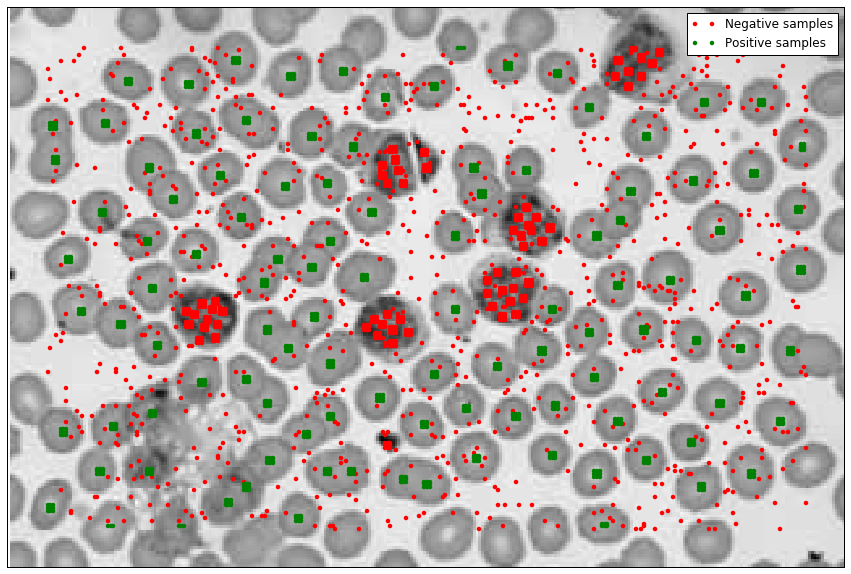

In [4]:
t_samples, t_labels, t_img = generate_training_data("train",
                                                box_size = box_size,
                                                sample_radius = sample_radius,
                                                enable_plotting = True)

## Generate validation data

In [5]:
v_samples, v_labels, v_img = generate_training_data("validation",
                                                box_size = box_size,
                                                sample_radius = sample_radius)

## Normalize data

In [6]:
mu = t_img.mean()
sigma = t_img.std()

def normalize(data):
    return (data - mu)/sigma

t_img = normalize(t_img)
v_img = normalize(v_img)

## Setup network

In [7]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')
network = setup_network(input_var, box_size)

## Setup objective function

In [8]:
# Training
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var).mean()
train_acc = T.mean(T.eq(T.argmax(prediction, axis=1), target_var), dtype=theano.config.floatX)
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=learning_rate, momentum=0.9)
train_fn = theano.function([input_var, target_var], [loss, train_acc], updates=updates, allow_input_downcast=True)

# Validation
val_prediction = lasagne.layers.get_output(network, deterministic=True)
val_loss = lasagne.objectives.categorical_crossentropy(val_prediction, target_var).mean()
val_acc = T.mean(T.eq(T.argmax(val_prediction, axis=1), target_var), dtype=theano.config.floatX)
val_fn = theano.function([input_var, target_var], [val_loss, val_acc], allow_input_downcast=True)

## Optimize parameters

In [9]:
for epoch in xrange(num_epochs):
    train_batches = 0
    val_batches = 0
    train_err = 0
    train_acc = 0
    val_err = 0
    val_acc = 0
    start_time = time.time()

    for batch in minibatch_iterator(t_samples, t_labels, t_img, box_size, batchsize = 100, shuffle=True):
        inputs, targets = batch
        err, acc = train_fn(inputs, targets)
        train_err += err
        train_acc += acc
        train_batches += 1

    for batch in minibatch_iterator(v_samples, v_labels, v_img, box_size, batchsize = 100, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t{:.6f}".format(train_err / train_batches))
    print("  Training accuracy:\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation loss:\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 15 took 15.238s
  training loss:	0.595468
  Training accuracy:	64.17 %
  validation loss:	0.384348
  validation accuracy:	92.76 %
Epoch 2 of 15 took 15.755s
  training loss:	0.331876
  Training accuracy:	87.13 %
  validation loss:	0.161213
  validation accuracy:	95.20 %
Epoch 3 of 15 took 15.634s
  training loss:	0.231903
  Training accuracy:	90.63 %
  validation loss:	0.135431
  validation accuracy:	95.80 %
Epoch 4 of 15 took 15.576s
  training loss:	0.181107
  Training accuracy:	92.96 %
  validation loss:	0.123276
  validation accuracy:	95.96 %
Epoch 5 of 15 took 15.678s
  training loss:	0.173926
  Training accuracy:	92.92 %
  validation loss:	0.119337
  validation accuracy:	96.04 %
Epoch 6 of 15 took 14.823s
  training loss:	0.161114
  Training accuracy:	94.33 %
  validation loss:	0.117421
  validation accuracy:	96.28 %
Epoch 7 of 15 took 14.852s
  training loss:	0.151591
  Training accuracy:	94.42 %
  validation loss:	0.104439
  validation accuracy:	96.20 %
Epoch 8 of 15

## Sliding window

In [10]:
eval_fn = theano.function([input_var], val_prediction)
output = np.zeros((v_img.shape[0], v_img.shape[1], 2))

margin = int(math.floor(box_size / 2))
for x in xrange(margin, int(v_img.shape[0] - margin)):
    for y in xrange(margin, int(v_img.shape[1]-margin)):
        patch = v_img[x-margin:x+margin+1, y-margin:y+margin+1]
        patch = patch.reshape(1,1, box_size, box_size)
        output[x,y,:] = eval_fn(patch)

## Detect local maxima

In [11]:
heatmap = filters.gaussian_filter(output[:,:,1], 1) 
seg = heatmap>0.5
detections = np.where(np.multiply(seg, heatmap == filters.maximum_filter(heatmap, 3)))

## Plot detections

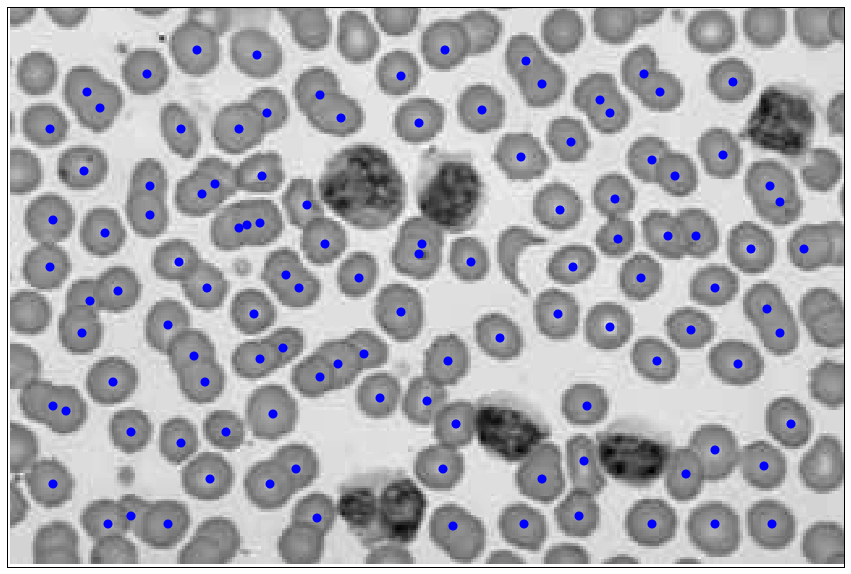

In [12]:
fig, ax = plt.subplots()
ax.imshow(v_img, interpolation='nearest', cmap=plt.cm.gray)
plt.plot(detections[1], detections[0], 'b.', markersize=12, mew=3)
        
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
plt.rcParams['figure.figsize'] = 20,20